In [3]:
import torch
from torch import nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class HSGLayer(nn.Module):
    def __init__(self, n_units, init_gates_closed):
        super(HSGLayer, self).__init__()
        self.W_R = nn.Linear(n_units, n_units, bias=False)
        self.W_F = nn.Linear(n_units, n_units)
        if init_gates_closed:
            self.W_F.bias = nn.Parameter(torch.Tensor([-2.5]*n_units).cuda())
    def forward(self, s_L_t, s_prime_tm1):
        g = torch.sigmoid(self.W_R(s_prime_tm1) + self.W_F(s_L_t))
        s_prime_t = g*s_prime_tm1 + (1 - g)*s_L_t
        return s_prime_t

class RHNCell(nn.Module):
    def __init__(self, in_feats, n_units, rec_depth=3, couple_gates=True,
                 use_HSG=False, init_gates_closed=False):
        super(RHNCell, self).__init__()
        self.rec_depth = rec_depth
        self.in_feats = in_feats
        self.n_units = n_units
        self.couple_gates = couple_gates
        self.use_HSG = use_HSG
        self.W_H = nn.Linear(in_feats, n_units, bias=False)
        self.W_T = nn.Linear(in_feats, n_units, bias=False)
        if not couple_gates:
            self.W_C = nn.Linear(in_feats, n_units, bias=False)
        self.R_H = nn.ModuleList([nn.Linear(n_units, n_units) for _ in range(rec_depth)])
        self.R_T = nn.ModuleList([nn.Linear(n_units, n_units) for _ in range(rec_depth)])
        if not couple_gates:
            self.R_C = nn.ModuleList([nn.Linear(n_units, n_units) for _ in range(rec_depth)])
        
        if use_HSG:
            self.HSG = HSGLayer(n_units, init_gates_closed)
        
        if init_gates_closed:
            for l in range(rec_depth):
                self.R_T[l].bias = nn.Parameter(torch.Tensor([-2.5]*n_units).cuda())
                if not couple_gates:
                    self.R_C[l].bias = nn.Parameter(torch.Tensor([-2.5]*n_units).cuda())
        
    def forward(self, x, s):
        if self.use_HSG:
            s_prime_tm1 = s
        preds = []
        for l in range(self.rec_depth):
            if l == 0:
                h_l_t = torch.tanh(self.W_H(x) + self.R_H[l](s))
                t_l_t = torch.sigmoid(self.W_T(x) + self.R_T[l](s))
                if not self.couple_gates:
                    c_l_t = torch.sigmoid(self.W_C(x) + self.R_C[l](s))
            else:
                h_l_t = torch.tanh(self.R_H[l](s))
                t_l_t = torch.sigmoid(self.R_T[l](s))
                if not self.couple_gates:
                    c_l_t = torch.sigmoid(self.R_C[l](s))
            
            if not self.couple_gates:
                s = h_l_t*t_l_t + c_l_t*s
            else:
                s = h_l_t*t_l_t + (1 - t_l_t)*s
            preds.append(s)
                
        if self.use_HSG:
            s = self.HSG(s, s_prime_tm1)
            preds.pop()
            preds.append(s)
        preds = torch.stack(preds)
        return s, preds

    
class RHN(nn.Module):
    def __init__(self, in_feats, out_feats, n_units=32, rec_depth=3, couple_gates=True, use_HSG=False,
                 init_gates_closed=False, use_batch_norm=False):
        super(RHN, self).__init__()
        assert rec_depth > 0
        self.rec_depth = rec_depth
        self.in_feats = in_feats
        self.n_units = n_units
        self.init_gates_closed = init_gates_closed
        self.couple_gates = couple_gates
        self.use_HSG = use_HSG
        self.use_batch_norm = use_batch_norm
        self.RHNCell = RHNCell(in_feats, n_units, rec_depth, couple_gates=couple_gates,
                               use_HSG=use_HSG, init_gates_closed=init_gates_closed)
        if use_batch_norm:
            self.bn_x = nn.BatchNorm1d(in_feats)
            self.bn_s = nn.BatchNorm1d(n_units)
    def forward(self, x):
        s = torch.zeros(x.shape[0], self.n_units).cuda()
        preds = []
        highway_states = []
        for t in range(x.shape[1]):
            if self.use_batch_norm:
                x_inp = self.bn_x(x[:, t, :])
                s = self.bn_s(s)
            else:
                x_inp = x[:, t, :]
            s, all_s = self.RHNCell(x_inp, s)
            preds.append(s)
            highway_states.append(all_s)
        preds = torch.stack(preds)
        preds = preds.permute(1, 0, 2)
        highway_states = torch.stack(highway_states)
        highway_states = highway_states.permute(2, 0, 3, 1)
        out = preds
        
        return out, highway_states

class ConvBlock(nn.Module):
    def __init__(self, T, in_channels, n_filters=32, filter_size=5):
        super(ConvBlock, self).__init__()
        padding1 = self._calc_padding(T, filter_size)
        self.conv = nn.Conv1d(in_channels, n_filters, filter_size, padding=padding1)
        self.relu = nn.ReLU()
        self.maxpool = nn.AdaptiveMaxPool1d(T)
        self.zp = nn.ConstantPad1d((1, 0), 0)
    def _calc_padding(self, Lin, kernel, stride=1, dilation=1):
        p = int(((Lin - 1) * stride + 1 + dilation * (kernel - 1) - Lin) / 2)
        return p
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)
        return x
    
    
class HARHN(nn.Module):
    def __init__(self, n_conv_layers, T, in_feats, target_feats, n_units_enc=32, n_units_dec=32, enc_input_size=32, rec_depth=3,
                 out_feats=1, n_filters=32, filter_size=5):
        super(HARHN, self).__init__()
        assert n_conv_layers > 0
        self.n_convs = n_conv_layers
        self.n_units_enc = n_units_enc
        self.n_units_dec = n_units_dec
        self.rec_depth = rec_depth
        self.T = T
        self.convs = nn.ModuleList([ConvBlock(T, in_feats, n_filters=n_filters, filter_size=filter_size) if i == 0 else ConvBlock(T, n_filters, n_filters=n_filters, filter_size=filter_size) for i in range(n_conv_layers)])
        self.conv_to_enc = nn.Linear(n_filters, enc_input_size)
        self.RHNEncoder = RHN(enc_input_size, out_feats=n_units_enc, n_units=n_units_enc, rec_depth=rec_depth)
        self.RHNDecoder = RHNCell(target_feats, n_units_dec, rec_depth=rec_depth)
        self.T_k = nn.ModuleList([nn.Linear(n_units_dec, n_units_enc, bias=False) for i in range(self.rec_depth)])
        self.U_k = nn.ModuleList([nn.Linear(n_units_enc, n_units_enc) for i in range(self.rec_depth)])
        self.v_k = nn.ModuleList([nn.Linear(n_units_enc, 1) for i in range(self.rec_depth)])
        self.W_tilda = nn.Linear(target_feats, target_feats, bias=False)
        self.V_tilda = nn.Linear(rec_depth*n_units_enc, target_feats)
        self.W = nn.Linear(n_units_dec, target_feats)
        self.V = nn.Linear(rec_depth*n_units_enc, target_feats)
    def forward(self, x, y):
        for l in range(self.n_convs):
            x = self.convs[l](x)
        x = self.conv_to_enc(x)
        x, h_T_L = self.RHNEncoder(x) # h_T_L.shape = (batch_size, T, n_units_enc, rec_depth)
        s = torch.zeros(x.shape[0], self.n_units_dec).cuda()
        for t in range(self.T):
            s_rep = s.unsqueeze(1)
            s_rep = s_rep.repeat(1, self.T, 1)
            d_t = []
            for k in range(self.rec_depth):
                h_T_k = h_T_L[..., k]
                a = self.U_k[k](h_T_k)
                b = self.T_k[k](s_rep)
                e_t_k = self.v_k[k](torch.tanh(self.T_k[k](s_rep) + self.U_k[k](h_T_k)))
                alpha_t_k = torch.softmax(e_t_k, 1)
                d_t_k = torch.sum(h_T_k*alpha_t_k, dim=1)
                d_t.append(d_t_k)
            d_t = torch.cat(d_t, dim=1)
            y_tilda_t = self.W_tilda(y[:, t, :]) + self.V_tilda(d_t)
            s, _ = self.RHNDecoder(y_tilda_t, s)
        
        y_T = self.W(s) + self.V(d_t)
        return y_T

In [6]:
data = pd.read_csv("date.txt")

In [7]:
data.shape


(122265, 3)

In [8]:
data.head()

,first_day_of_month,cfips,microbusiness_density
0,0.0,1001,3.007682
1,31.0,1001,2.884870
2,61.0,1001,3.055843
3,92.0,1001,2.993233
4,122.0,1001,2.993233


<AxesSubplot:>

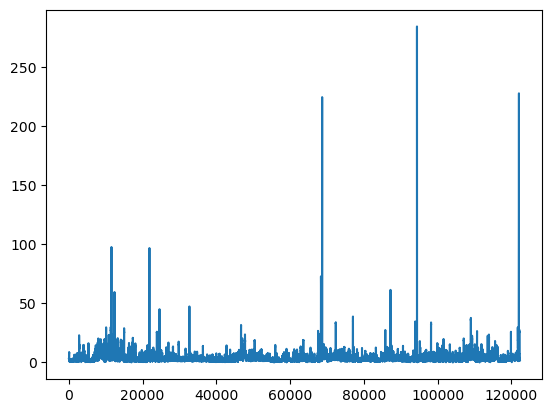

In [9]:
data["microbusiness_density"].plot()

In [10]:
# for my data 
batchsize = 128
timesteps = 16
n_timeseries = data.shape[1] - 1
print(n_timeseries)
train_length = int(data.shape[0] * 0.60)
val_length = int(data.shape[0] * 0.20)
test_length = int(data.shape[0]* 0.20)
target = "microbusiness_density"

2


In [11]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))

In [12]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")
# print("X.shape",X.shape)

In [13]:
for j in range(timesteps):
    y[:, j, 0] = data["microbusiness_density"].shift(timesteps - j - 1).fillna(method="bfill")
# print("y.shape",y.shape)

In [14]:
prediction_horizon = 1
target = data["microbusiness_density"].shift(-prediction_horizon).fillna(method="ffill").values
# print(target)
# print("target.shape", target.shape, "target len", len(target))

In [15]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]
# print("X.shape",X.shape)
# print("y.shape",y.shape)
# print("target.shape",target.shape)

In [16]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

# print("X_train", X_train.shape, "y_his_train", y_his_test.shape)
# print("x_val",X_val.shape, "y_his_val", y_his_val.shape)
# print("x_test", X_test.shape,"y_his_test",y_his_test.shape)
# print("target_train", target_train.shape, "target_val", target_val.shape, "target_test", target_test.shape )

In [17]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [18]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [19]:
# Converting into tensors

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [20]:
# print("X_train.shape", X_train.shape)
# print(" n_conv_layers: 3 T:",X_train.shape[1], "in_feats",X_train.shape[2], "target_feats", 1)
# print("X_tarin",X_train)

In [21]:
model = HARHN(3, X_train.shape[1], X_train.shape[2], 1, n_units_enc=64, n_units_dec=64).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [23]:
from torch.utils.data import TensorDataset, DataLoader
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batchsize)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batchsize)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batchsize)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [29]:
loss = nn.MSELoss()

Saving...
Iter:  0 train:  0.010747495224689662 val:  0.014730103374626356
mse:  10.939369 mae:  1.0135548


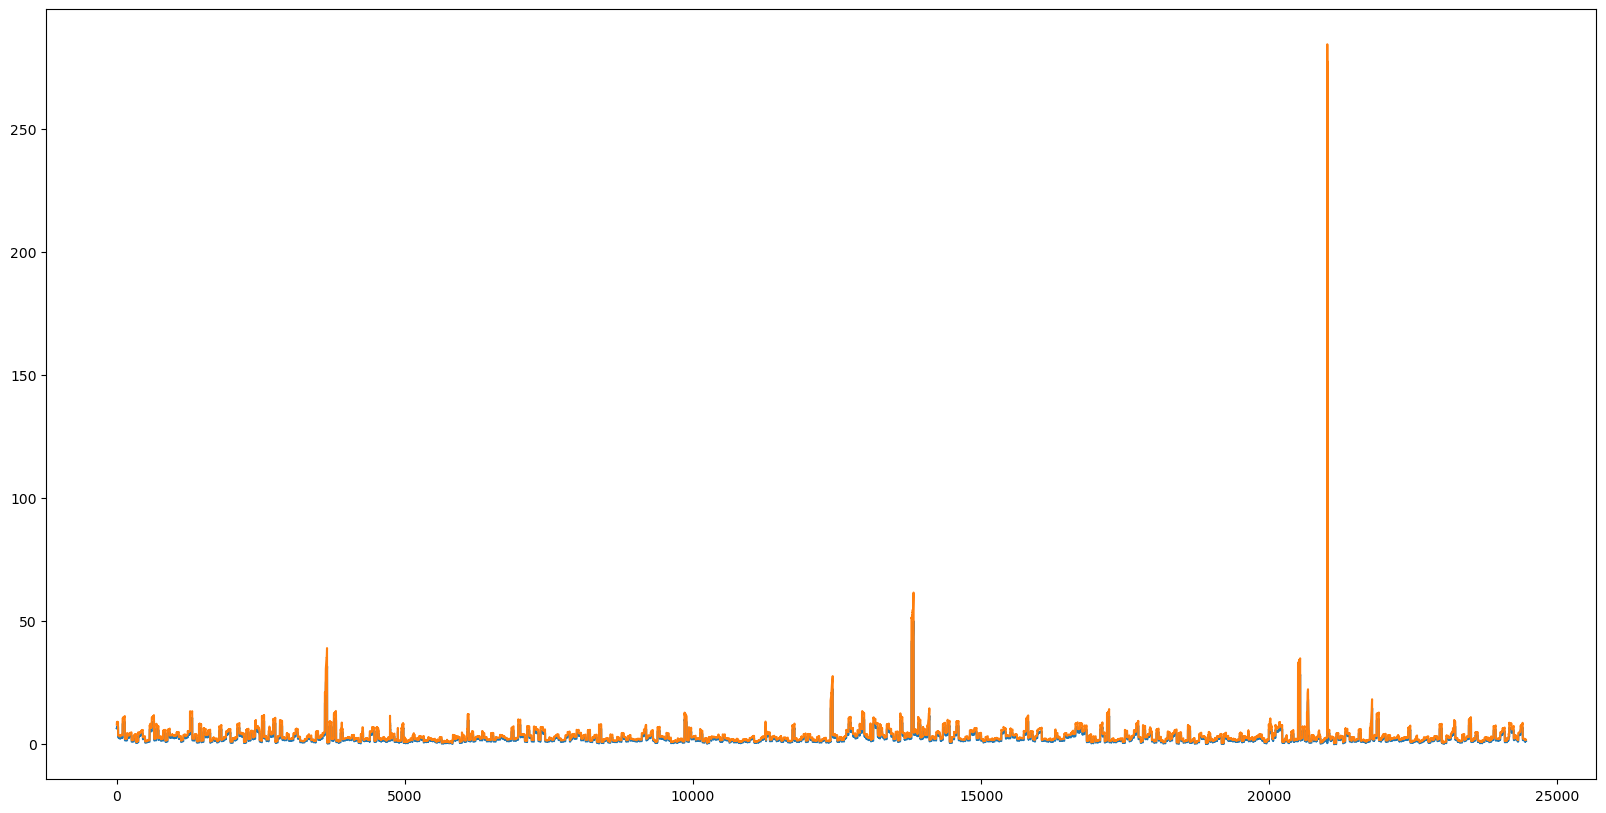

Iter:  1 train:  0.007266005777907107 val:  0.015779348175504533
Iter:  2 train:  0.007173735281920855 val:  0.015247079791004552
Iter:  3 train:  0.006943825221901339 val:  0.015380973652334406
Iter:  4 train:  0.006882808603524522 val:  0.014966225102423548
Iter:  5 train:  0.007104345380071813 val:  0.015501063687419816
Iter:  6 train:  0.007301883244728168 val:  0.014822212783300223
Saving...
Iter:  7 train:  0.006912795941303375 val:  0.014283655251343178
Iter:  8 train:  0.0069389070076210126 val:  0.014779814284740405
Iter:  9 train:  0.0067668328371173645 val:  0.014777722818960125
Iter:  10 train:  0.0067050315268915375 val:  0.014917727491386725
mse:  11.219824 mae:  0.36372414


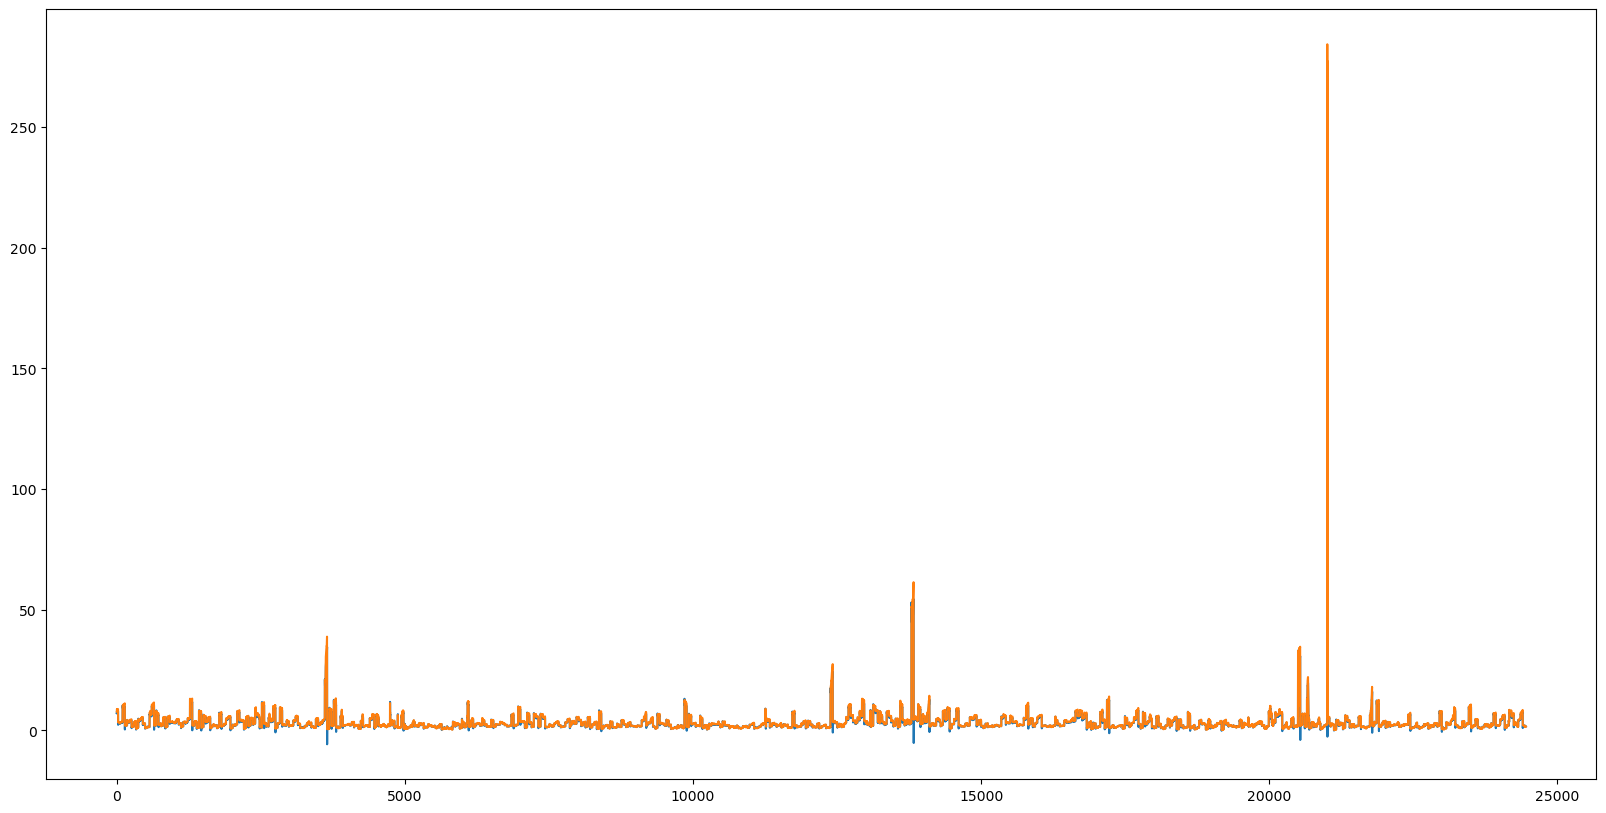

Iter:  11 train:  0.006875635492599863 val:  0.014620544959699652
Saving...
Iter:  12 train:  0.0066545230456256516 val:  0.013818801771117422
Iter:  13 train:  0.006700179831655397 val:  0.013896914554582558
Iter:  14 train:  0.006849775031278368 val:  0.014532913731346377
Iter:  15 train:  0.0068679094483576585 val:  0.013955132998811131
Iter:  16 train:  0.006644492313893032 val:  0.014418964889297312
Iter:  17 train:  0.006489759162964734 val:  0.014090135267486294
Iter:  18 train:  0.006802140222601564 val:  0.01515409272575041
Iter:  19 train:  0.006406840309610092 val:  0.014553668458328122
Iter:  20 train:  0.0065449778227223915 val:  0.014748968895102722
mse:  10.967407 mae:  0.19387984


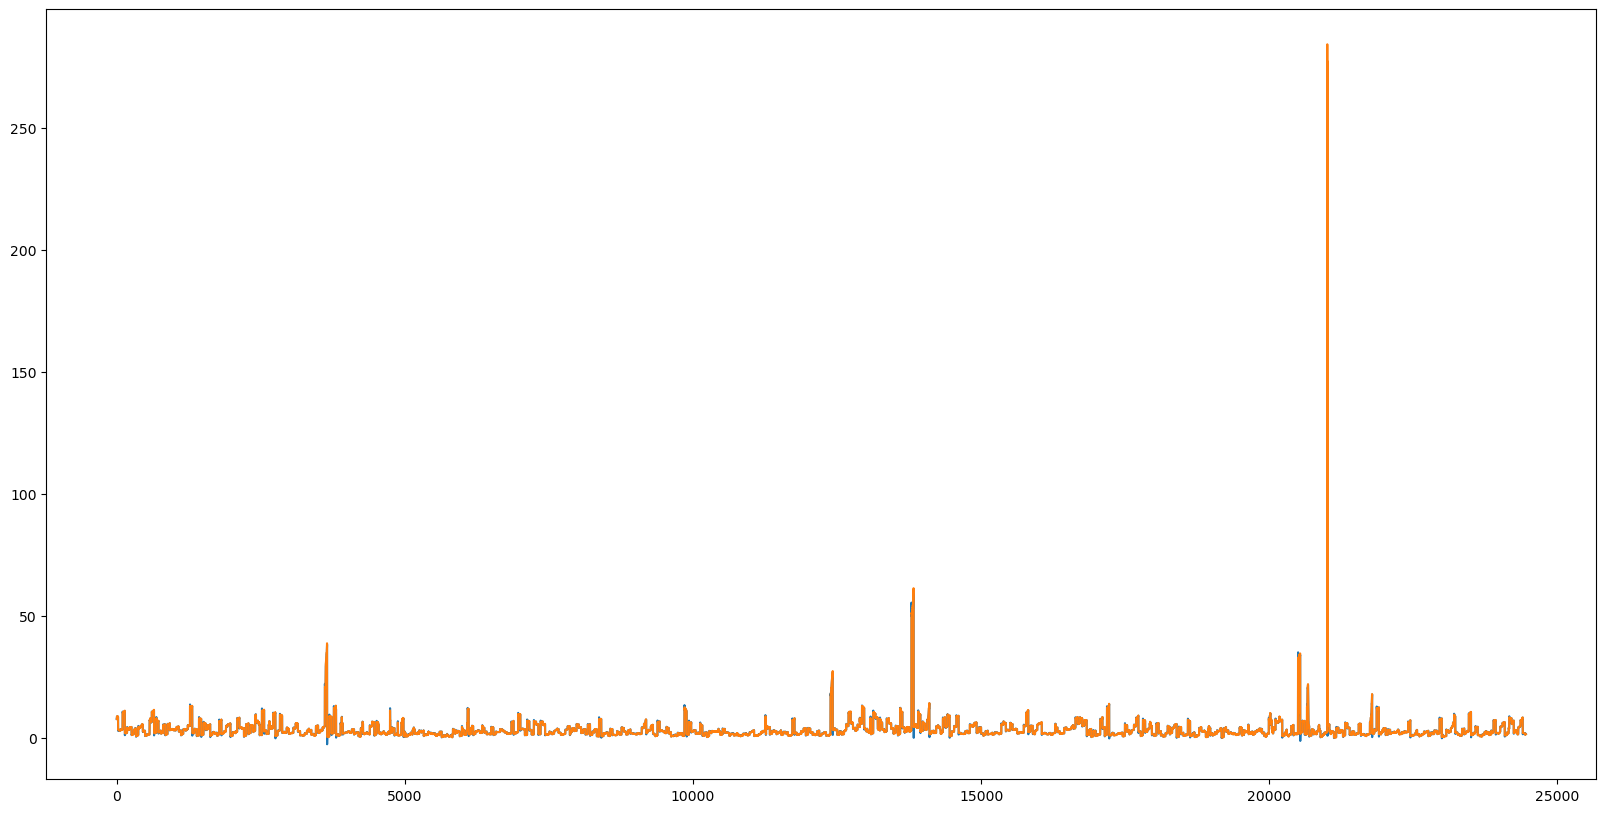

Iter:  21 train:  0.006500674270893823 val:  0.014836889599274457
Iter:  22 train:  0.006517570766687901 val:  0.01428111733254033
Iter:  23 train:  0.006453206632274622 val:  0.014859247685533825
Iter:  24 train:  0.006603373637026964 val:  0.014692157621833069
Iter:  25 train:  0.006547791290268729 val:  0.013828631198199815
Iter:  26 train:  0.0064443249903514575 val:  0.014685689791614864
Saving...
Iter:  27 train:  0.00646752380830845 val:  0.01323002488378026
Iter:  28 train:  0.006485823761807218 val:  0.015383760878279909
Iter:  29 train:  0.006528010717413013 val:  0.01467802470482021
Iter:  30 train:  0.006377758786388931 val:  0.015479074577218421
mse:  12.080103 mae:  0.2779145


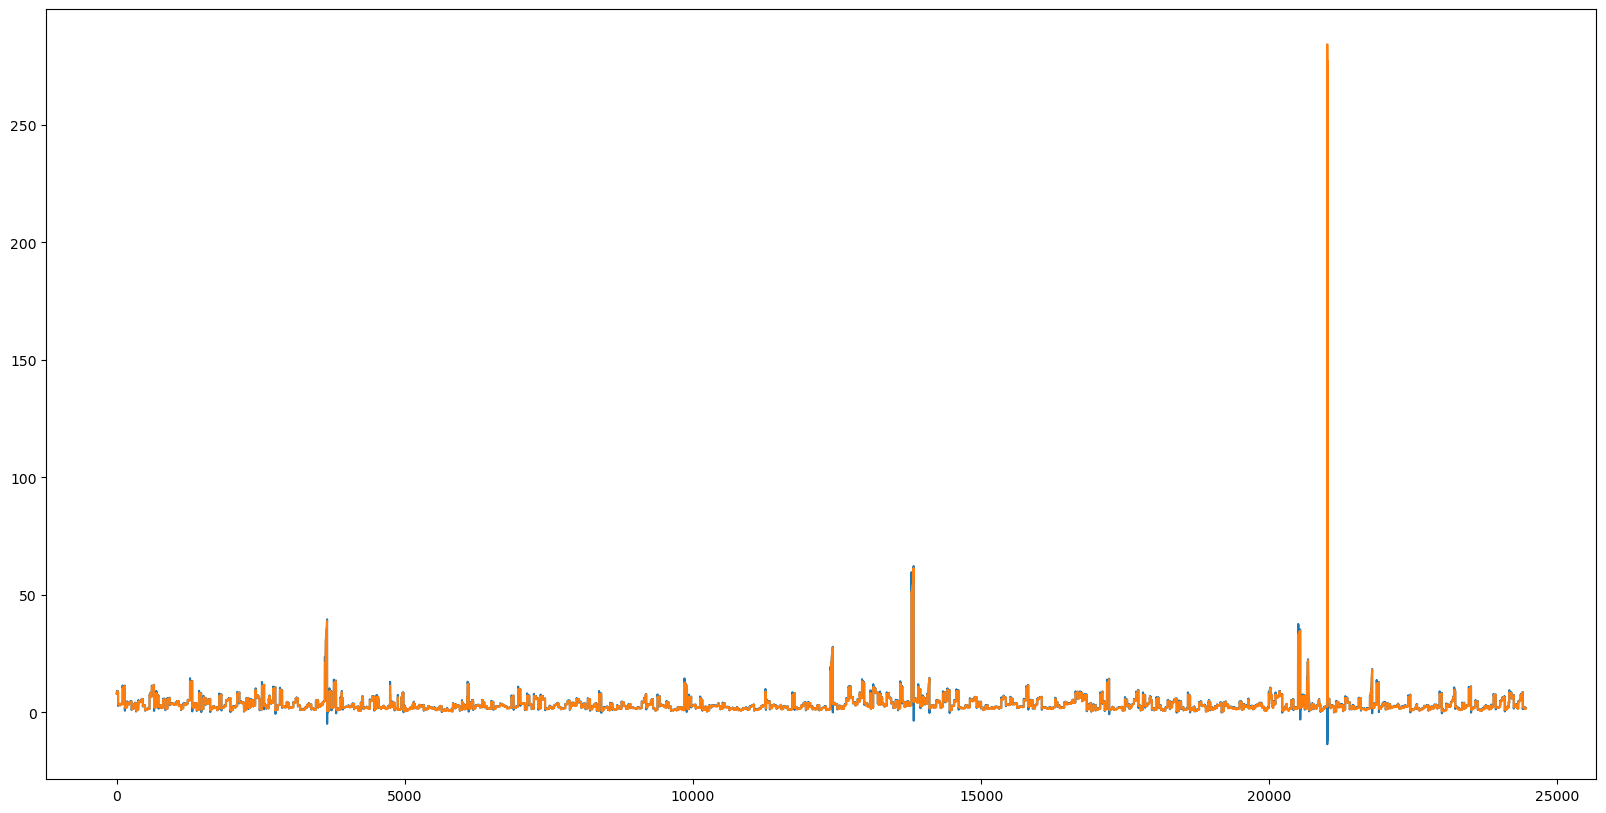

Iter:  31 train:  0.00639426465133389 val:  0.015633293527953635
Iter:  32 train:  0.006553086995687575 val:  0.015390800327012951
Iter:  33 train:  0.00642183250327861 val:  0.015145523948352526
Iter:  34 train:  0.0063456791596425465 val:  0.014343343673358237
Iter:  35 train:  0.006498887793631191 val:  0.014534649395464982
Iter:  36 train:  0.006390434267015182 val:  0.014784478734299441
Iter:  37 train:  0.006531410371153873 val:  0.014726928786670042
Iter:  38 train:  0.006446741477908759 val:  0.013716478980306951
Iter:  39 train:  0.006060420259841176 val:  0.013869558684041544
Iter:  40 train:  0.006608754893253666 val:  0.013922586522939493
mse:  9.772833 mae:  0.59290516


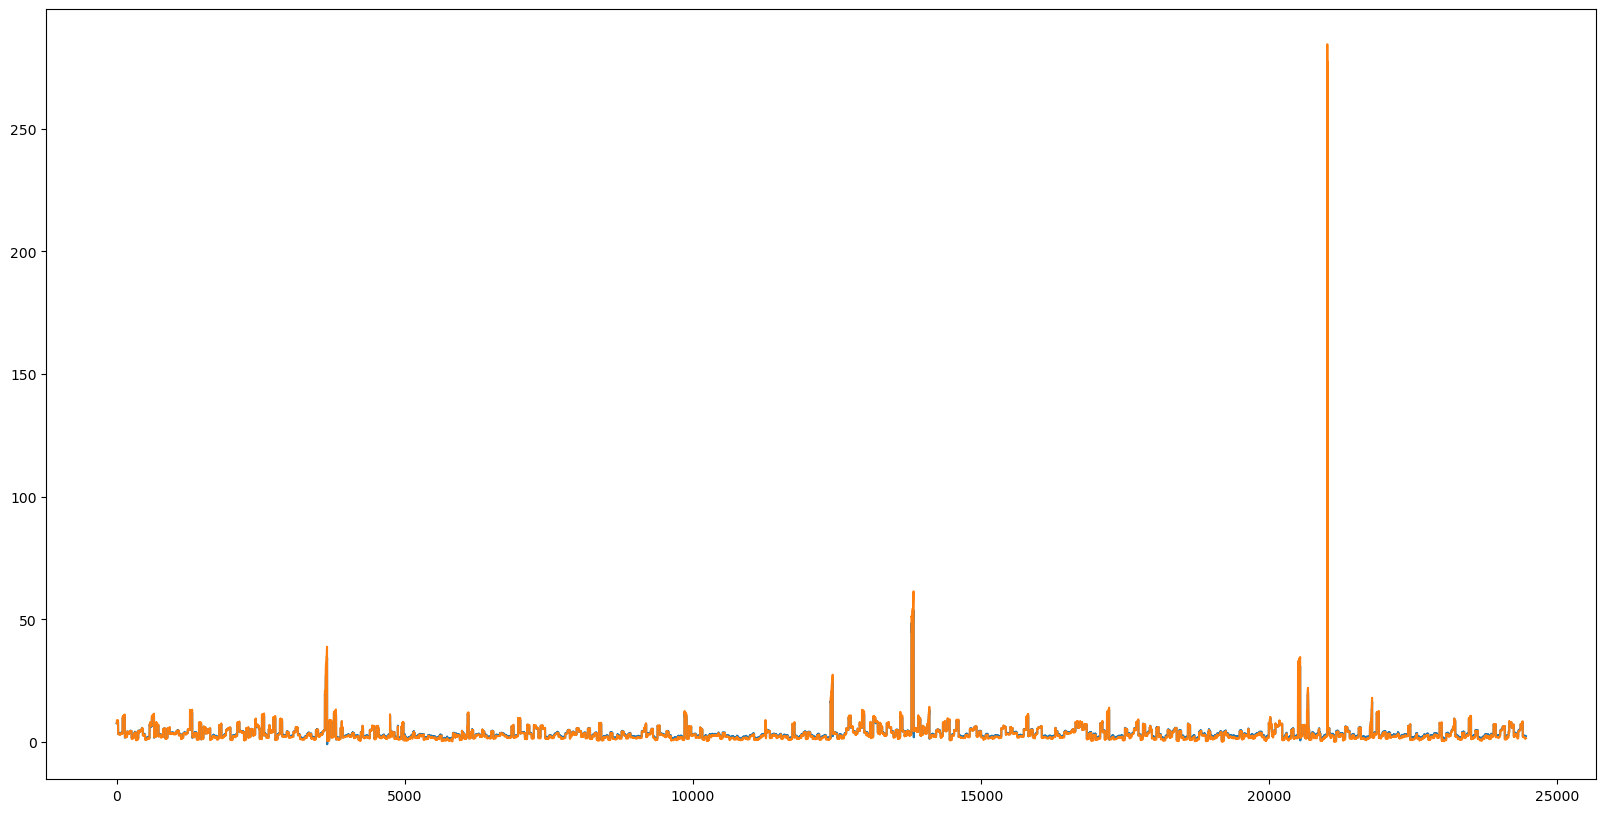

Saving...
Iter:  41 train:  0.006461553237554099 val:  0.013099199460153983
Iter:  42 train:  0.006346144566149329 val:  0.014815155271503589
Iter:  43 train:  0.006402294079449753 val:  0.013323665682002299
Iter:  44 train:  0.006344804534198929 val:  0.014672121789739402
Iter:  45 train:  0.006367015047500381 val:  0.013864531906213846
Iter:  46 train:  0.00632261959374948 val:  0.013904175703759625
Iter:  47 train:  0.006393243061008924 val:  0.014019859655272297
Iter:  48 train:  0.006386612826099742 val:  0.013552534738862568
Iter:  49 train:  0.00632313298225062 val:  0.014551998190201426
Iter:  50 train:  0.00629544283531744 val:  0.014682095798331466
mse:  10.868178 mae:  0.27558354


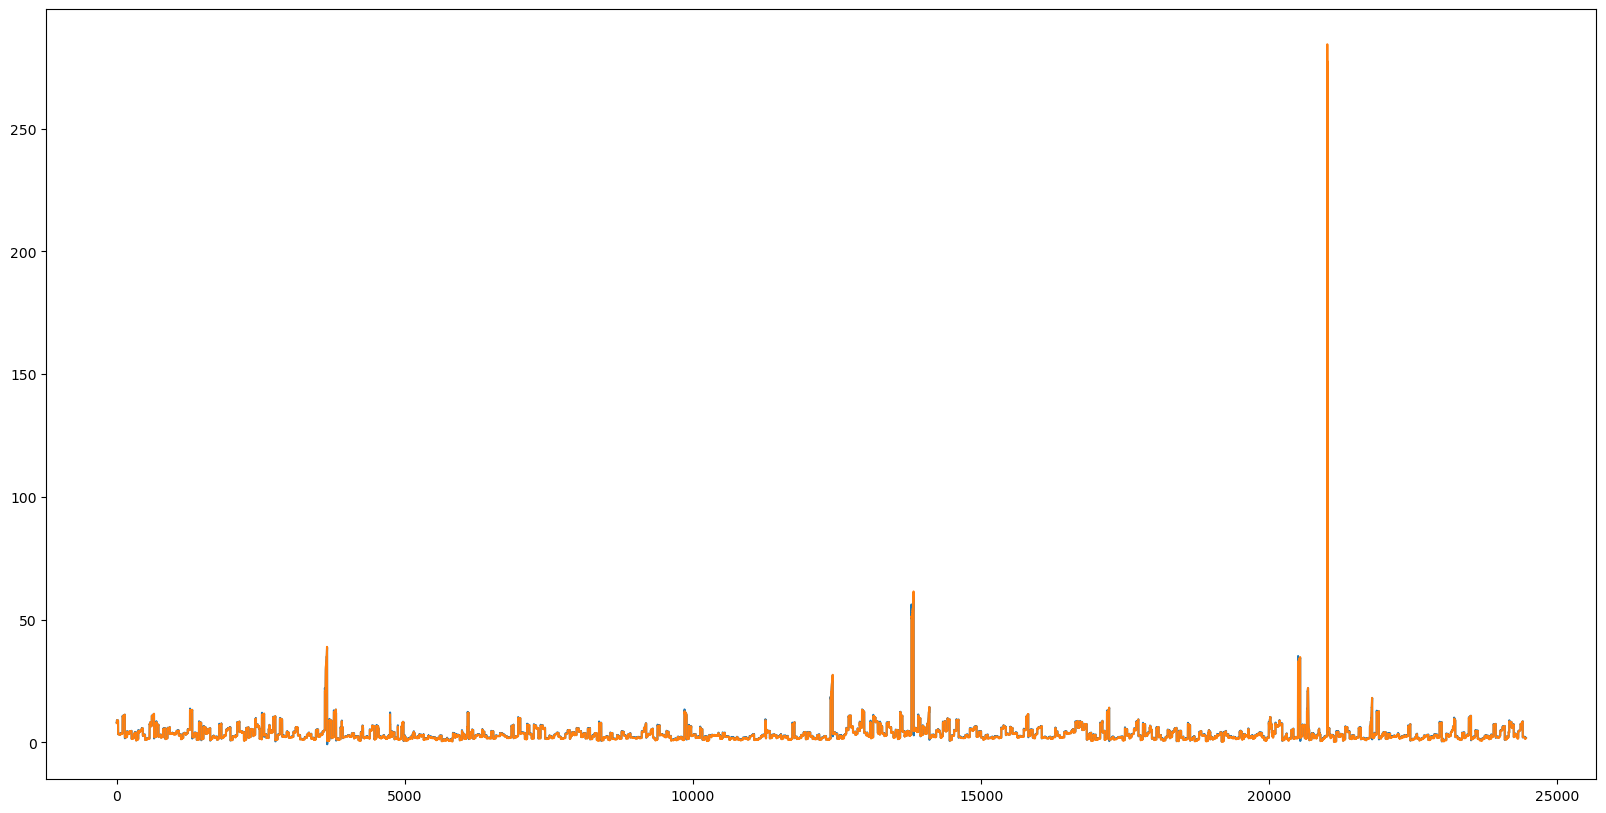

Iter:  51 train:  0.006413901842878852 val:  0.014717484252400529
Iter:  52 train:  0.006349639738048063 val:  0.013797259024766586
Iter:  53 train:  0.006426264172162232 val:  0.014480087277322251
Iter:  54 train:  0.006298256779420991 val:  0.015186825180444648
Iter:  55 train:  0.006272257914805536 val:  0.013886180635768705
Iter:  56 train:  0.006273797978414373 val:  0.013254729752445654
Iter:  57 train:  0.006288221692044217 val:  0.014326283996025979
Iter:  58 train:  0.0062993210090299045 val:  0.013960554602720549
Iter:  59 train:  0.006320264665824257 val:  0.014456881241703164
Iter:  60 train:  0.006194559702835636 val:  0.014227472498187314
mse:  10.2055435 mae:  0.6963746


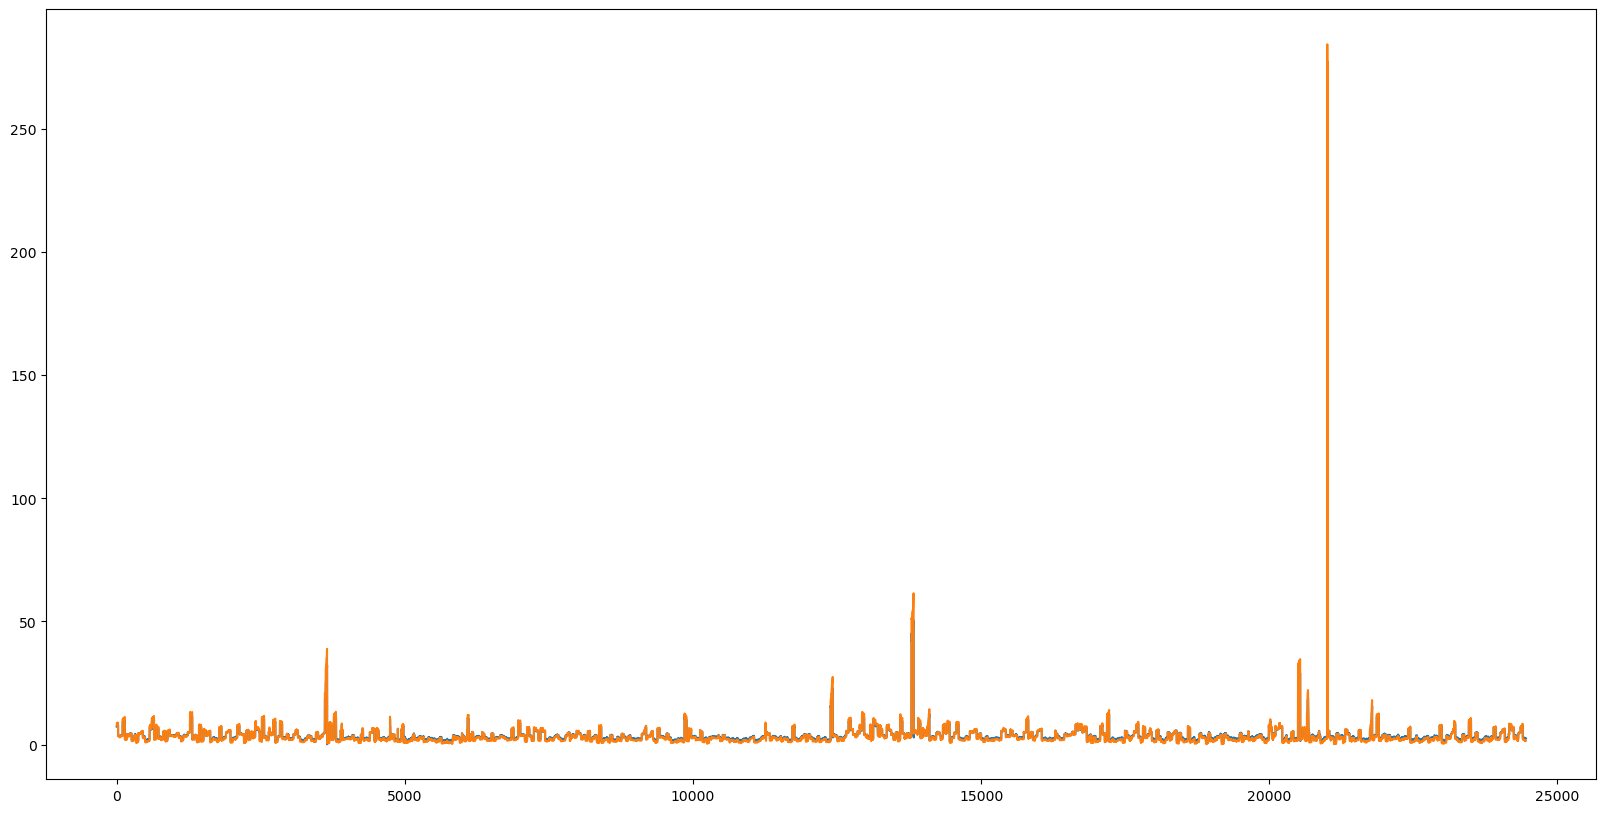

Iter:  61 train:  0.006406722371295474 val:  0.014513999008169
Iter:  62 train:  0.006359715016631067 val:  0.014086533124741691
Iter:  63 train:  0.006284379696268589 val:  0.015122072931585594
Iter:  64 train:  0.006311611992846869 val:  0.014612312957509952
Iter:  65 train:  0.006284882775470601 val:  0.014489767146052978
Iter:  66 train:  0.006328445975116682 val:  0.01434071880009819
Iter:  67 train:  0.006301379519106765 val:  0.015123627356359765
Iter:  68 train:  0.0063075095552052604 val:  0.013390357706138787
Iter:  69 train:  0.006307036143682925 val:  0.015146629209230383
Iter:  70 train:  0.006204760474687927 val:  0.013456023714601346
mse:  9.128809 mae:  0.4290641


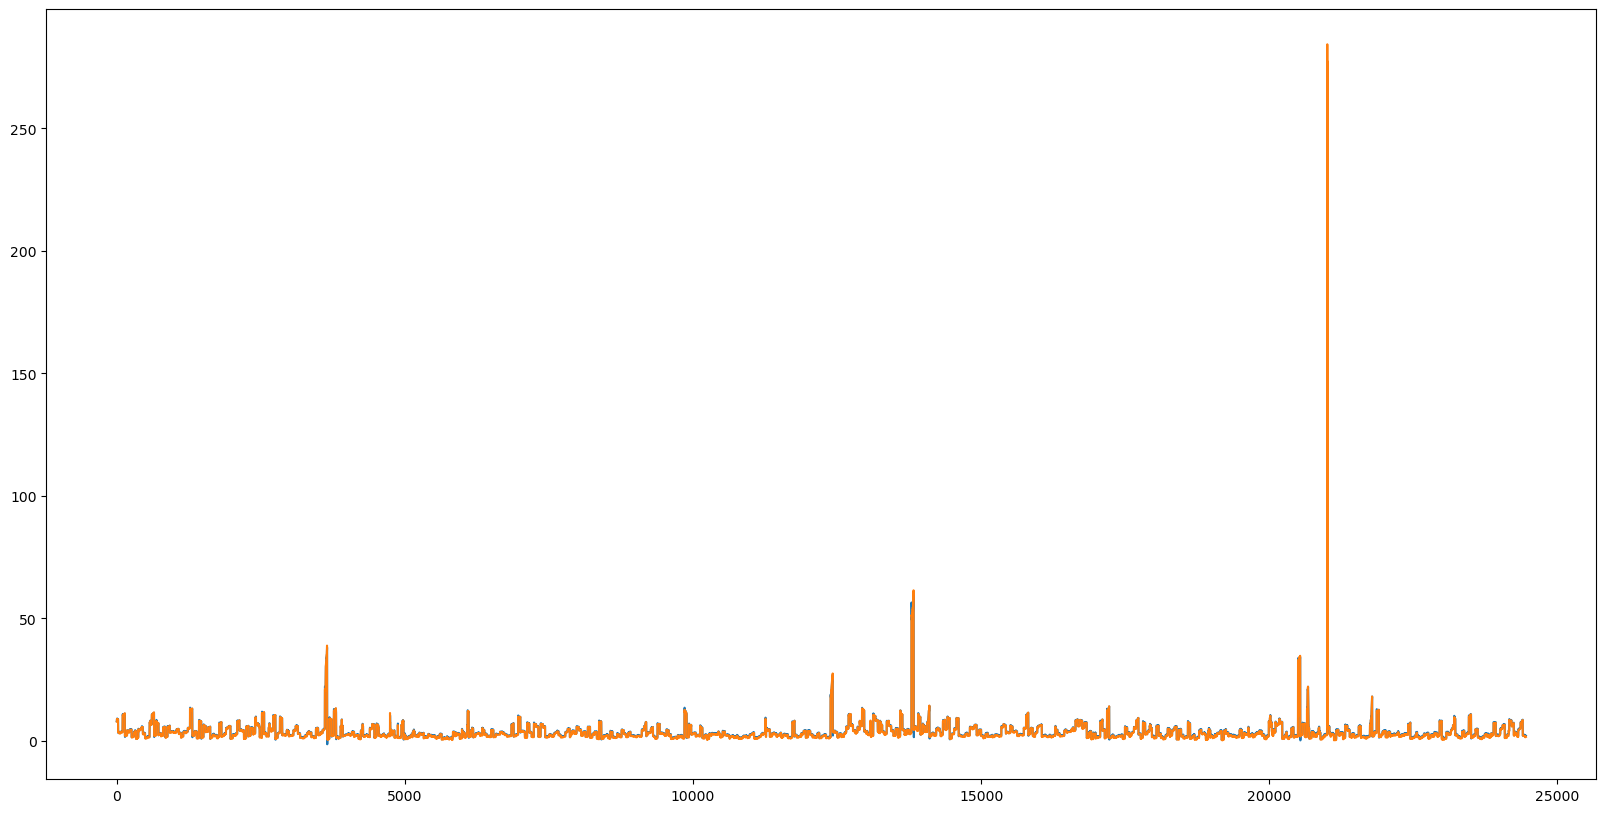

Iter:  71 train:  0.006239521463873287 val:  0.01493214987303228
Iter:  72 train:  0.006332180930975215 val:  0.014771290681404587
Iter:  73 train:  0.006130483482505346 val:  0.014389742104846039
Iter:  74 train:  0.006293258916807012 val:  0.015509564066599181
Iter:  75 train:  0.006264743079680966 val:  0.0145355303626752
Iter:  76 train:  0.006310770441594729 val:  0.015127720624842784
Iter:  77 train:  0.0062848877075851965 val:  0.014930491670310487
Iter:  78 train:  0.006176456555860554 val:  0.014642783459093542
Iter:  79 train:  0.00633270894436215 val:  0.01490109380851532
Iter:  80 train:  0.006280250455893526 val:  0.014816838269426758
mse:  11.068576 mae:  0.398165


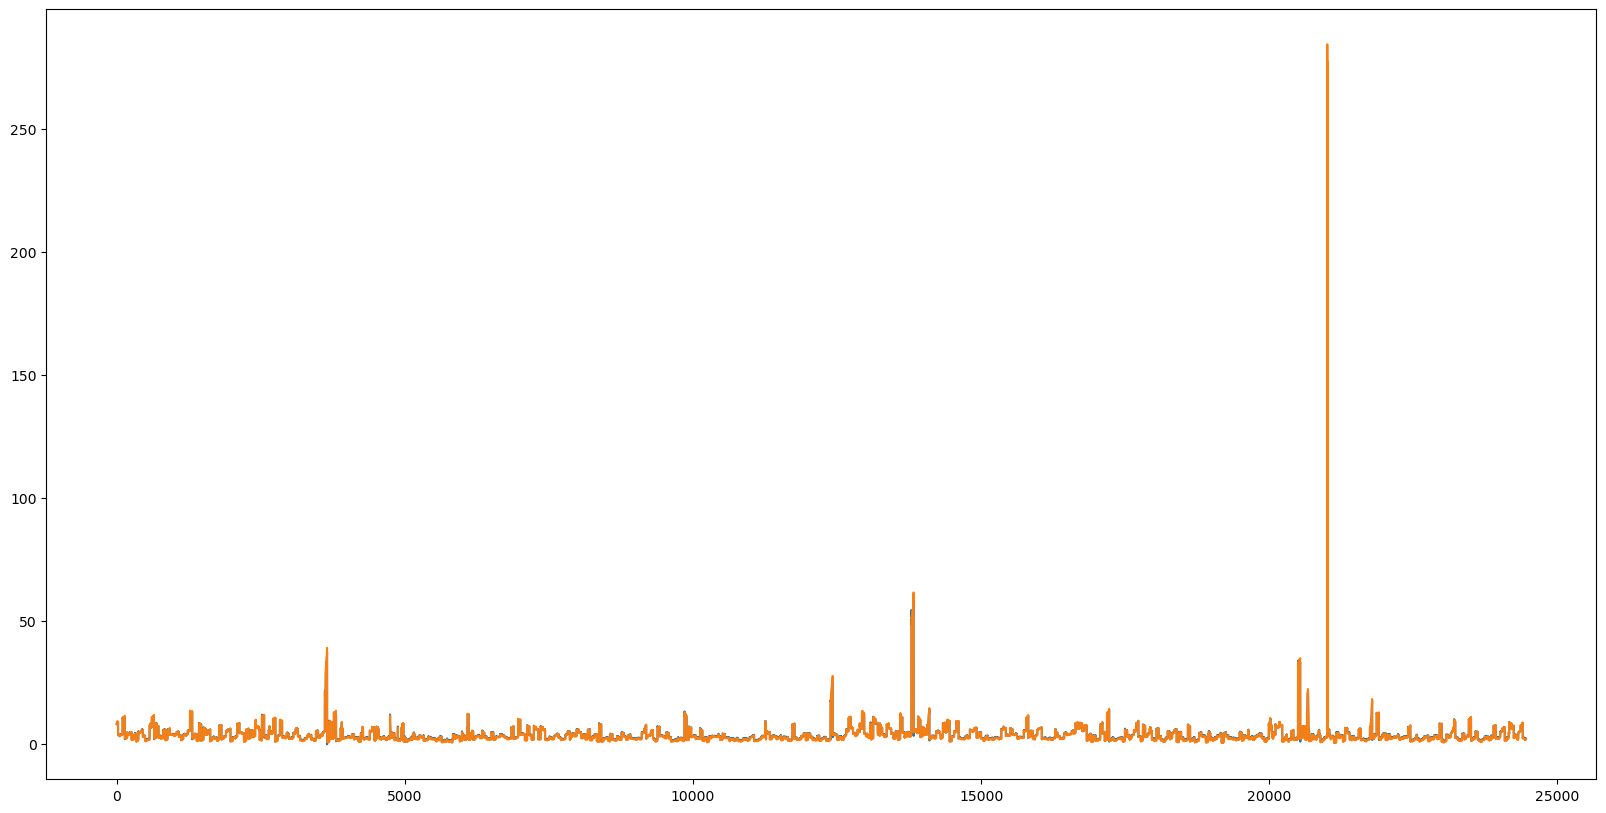

Iter:  81 train:  0.006260578901075293 val:  0.01428406145224647
Iter:  82 train:  0.0062474077617305735 val:  0.014238780308370837
Iter:  83 train:  0.006220181376617898 val:  0.014666057176252238
Iter:  84 train:  0.006181431344268091 val:  0.014954327577075209
Iter:  85 train:  0.0062061900935180036 val:  0.015166257893405066
Iter:  86 train:  0.006242864981872117 val:  0.01423600776533816
Iter:  87 train:  0.006218213159956209 val:  0.015438054135649033
Iter:  88 train:  0.006251065473995401 val:  0.01448673472186747
Iter:  89 train:  0.006300647341726184 val:  0.013915543967306886
Iter:  90 train:  0.006330851068335707 val:  0.01391270185951403
mse:  9.758962 mae:  0.20311944


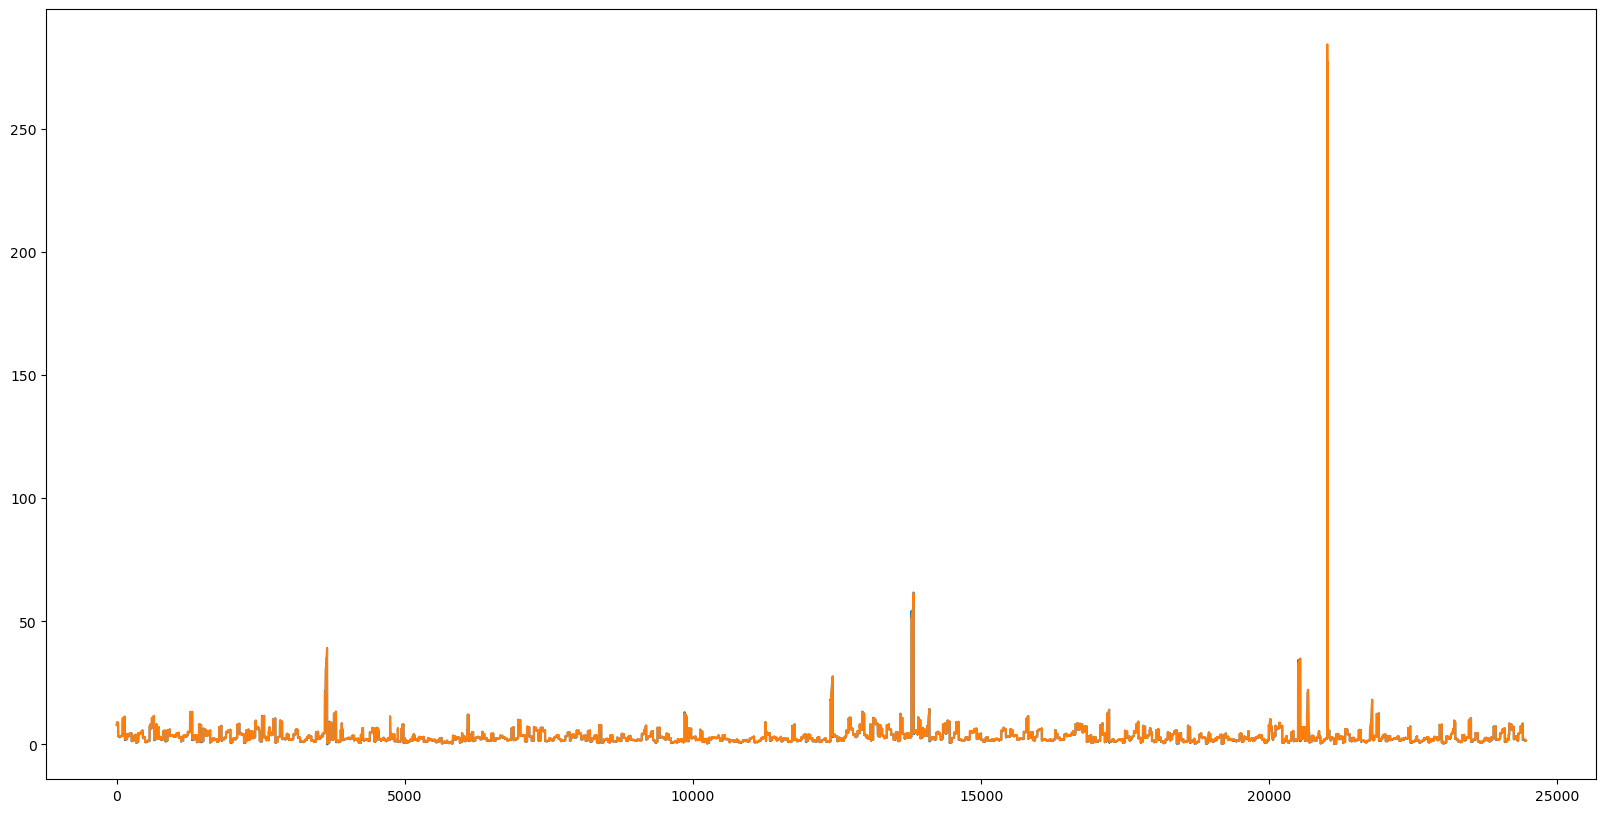

Iter:  91 train:  0.006244768179592286 val:  0.013878895889641335
Iter:  92 train:  0.006195131612279025 val:  0.01407427561440198
Iter:  93 train:  0.006250318227287097 val:  0.013531834983070921
Iter:  94 train:  0.006182047414938143 val:  0.013456705762200708
Iter:  95 train:  0.006173313824165385 val:  0.01340456383321532
Iter:  96 train:  0.006245624774902748 val:  0.013889002167955338
Iter:  97 train:  0.006263708982902472 val:  0.014033361244580298
Iter:  98 train:  0.006198047219742498 val:  0.013636632202745162
Iter:  99 train:  0.006221175175863406 val:  0.01459455686672068
Iter:  100 train:  0.006220304841900704 val:  0.01402498112073485
mse:  9.917112 mae:  0.18841662


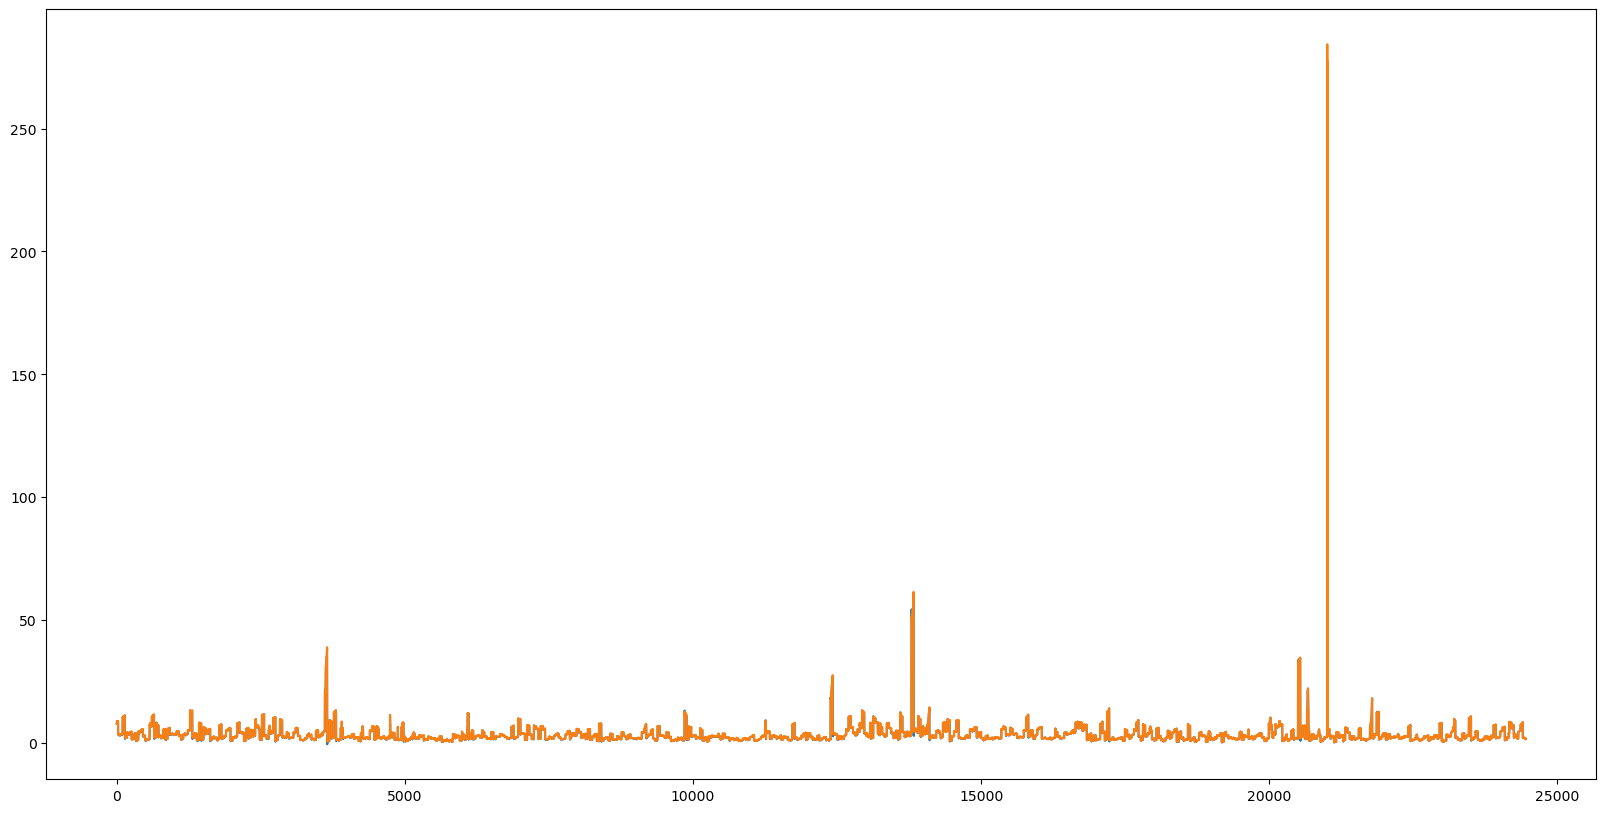

Iter:  101 train:  0.006207881211622728 val:  0.014706960112399067
Iter:  102 train:  0.006121680452431674 val:  0.01486849985763818
Iter:  103 train:  0.006176143611148228 val:  0.014591318080374553
Iter:  104 train:  0.006185751017959984 val:  0.01435907667357782
Iter:  105 train:  0.006213487810482568 val:  0.013864891945249801
Iter:  106 train:  0.006150901544506692 val:  0.014317559981686748
Iter:  107 train:  0.006214204826168214 val:  0.014338829347717873
Iter:  108 train:  0.006447818127291098 val:  0.015229490494109819
Iter:  109 train:  0.006215256152613848 val:  0.014883800220606102
Iter:  110 train:  0.0062532367512521825 val:  0.014672996948562505
mse:  10.854715 mae:  0.18069114


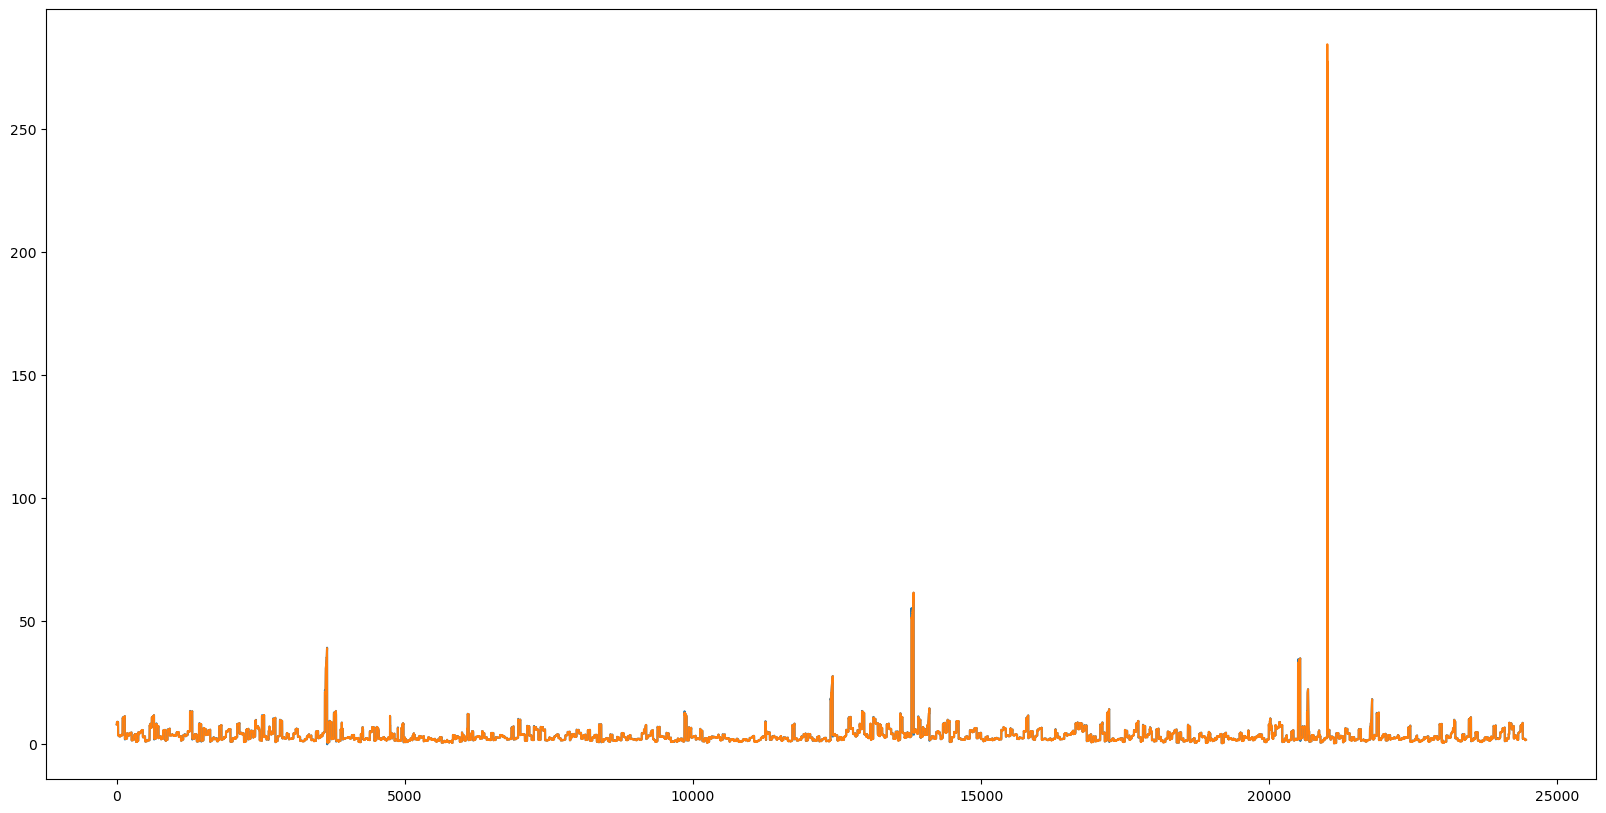

Iter:  111 train:  0.006213717114252807 val:  0.014406003291264916
Iter:  112 train:  0.0061607919333242995 val:  0.014140592052390764
Iter:  113 train:  0.006193755910110136 val:  0.013594389381637878
Iter:  114 train:  0.006189007733012958 val:  0.013733513614388133
Iter:  115 train:  0.0062086870466141805 val:  0.014280950458724259
Iter:  116 train:  0.006144841936658753 val:  0.013954986749658527
Iter:  117 train:  0.006168928947179673 val:  0.014239764629725999
Iter:  118 train:  0.006323252351080945 val:  0.013300961813926477
Iter:  119 train:  0.006214995722960777 val:  0.01367931884974324
Iter:  120 train:  0.006122739873614014 val:  0.013187322768275478
mse:  8.767865 mae:  0.1789446


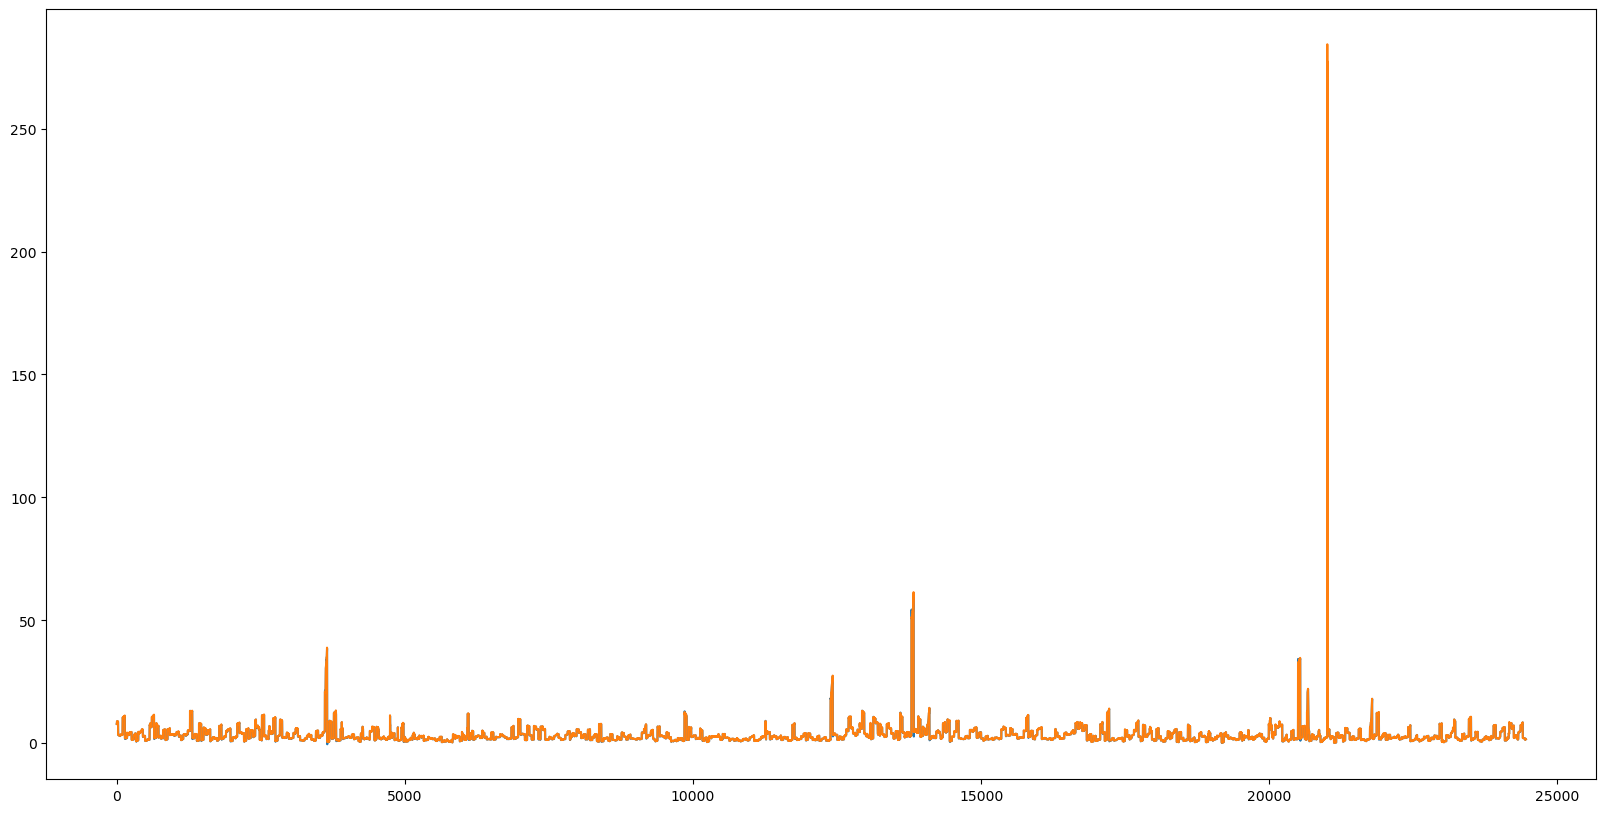

Iter:  121 train:  0.0062679935172368405 val:  0.013719185461058537
Iter:  122 train:  0.008606077905162619 val:  0.014118370708259562
Iter:  123 train:  0.006876475869999556 val:  0.013979193784062175
Iter:  124 train:  0.006287348556827729 val:  0.013494181910702495
Iter:  125 train:  0.006263331273375703 val:  0.013506401502643081
Iter:  126 train:  0.006085754210795071 val:  0.013741160665534595
Iter:  127 train:  0.006184103050835867 val:  0.013588185177741147
Iter:  128 train:  0.006134366110508955 val:  0.013823218998424307
Iter:  129 train:  0.006213685212520344 val:  0.013667353547839267
Iter:  130 train:  0.006088418148483663 val:  0.014139940213961073
mse:  10.080357 mae:  0.3448836


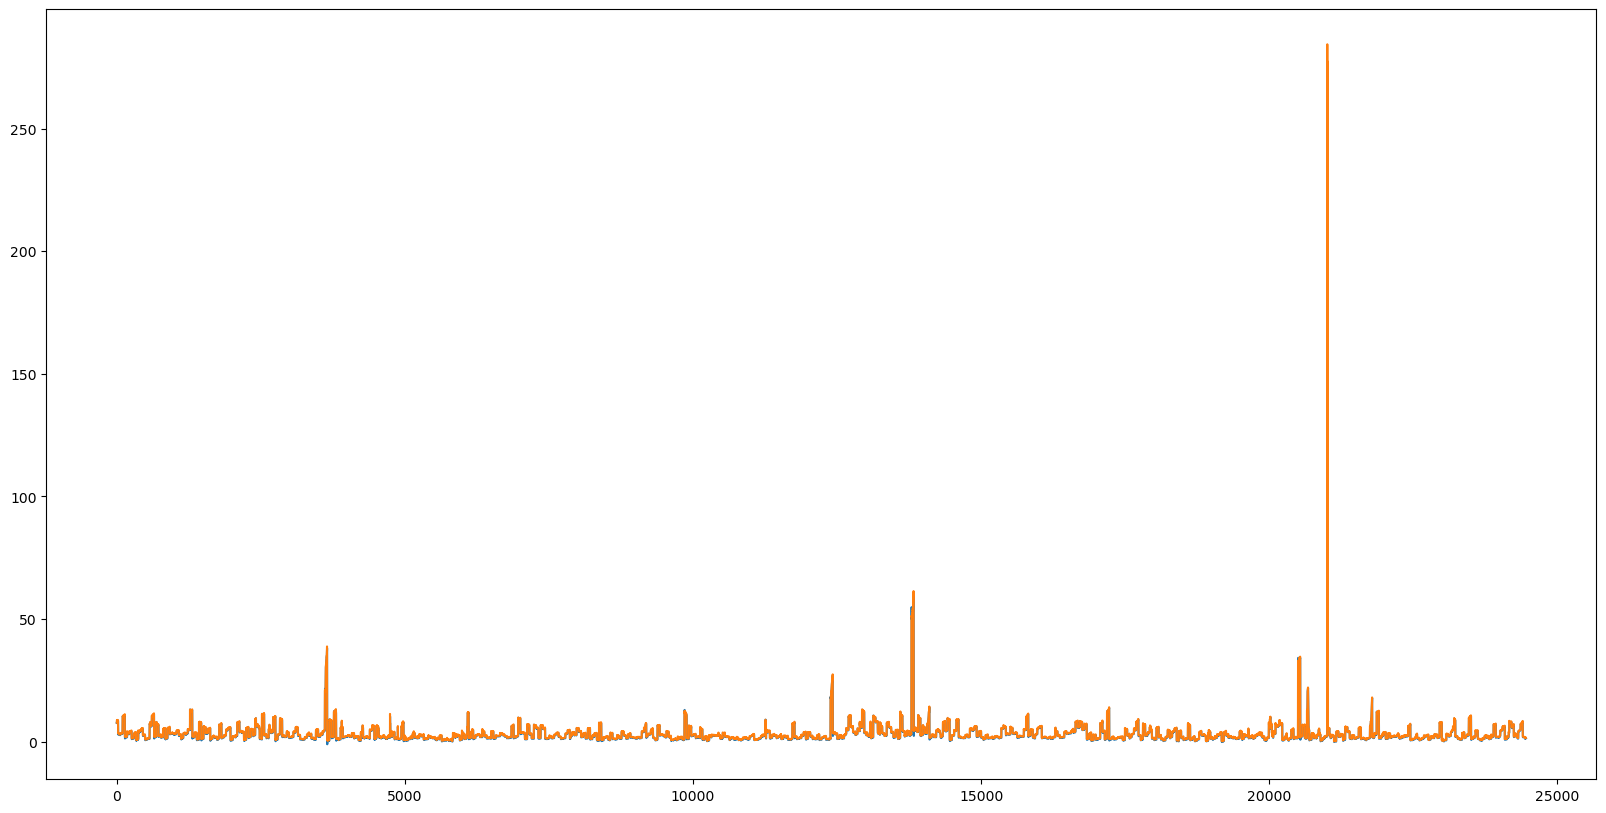

Iter:  131 train:  0.006023731566374627 val:  0.014269705638216447
Iter:  132 train:  0.006266760101118447 val:  0.01391094787523364
Iter:  133 train:  0.0061422646685630675 val:  0.013754095141395015
Iter:  134 train:  0.006157550356122874 val:  0.013529732741381138
Iter:  135 train:  0.006125906297553393 val:  0.013476395723392372
Iter:  136 train:  0.006234153513472225 val:  0.014198766505925045
Iter:  137 train:  0.006240224785351885 val:  0.013115318269354716
Iter:  138 train:  0.006674021607188713 val:  0.013390387808065158
Iter:  139 train:  0.006192498344123998 val:  0.013233221396883843
Iter:  140 train:  0.006062460230881511 val:  0.013105452697812506
mse:  8.659337 mae:  0.35329506


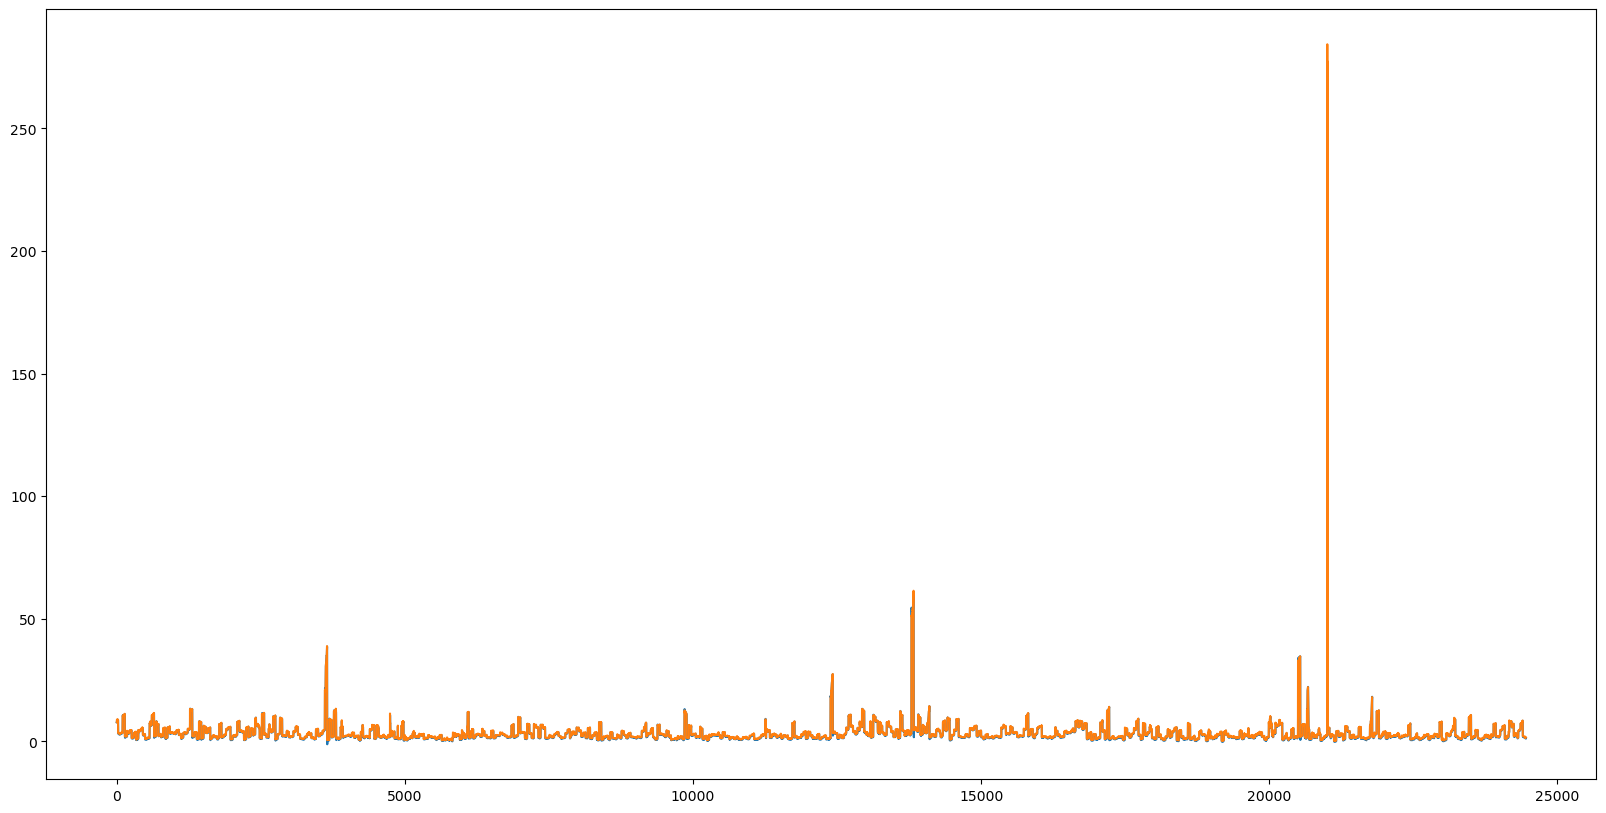

Iter:  141 train:  0.006026437906610972 val:  0.013698923913942377
Iter:  142 train:  0.006169543101098608 val:  0.013792996532355398
Iter:  143 train:  0.006189202930577463 val:  0.013326794508279942
Saving...
Iter:  144 train:  0.006134282694220527 val:  0.012983485302138224
Iter:  145 train:  0.006099524700073738 val:  0.013614584317283974
Iter:  146 train:  0.006100357411456775 val:  0.012991032158225314
Iter:  147 train:  0.006106516348240008 val:  0.013518920093679419
Iter:  148 train:  0.0062759686365186345 val:  0.014029454421051126
Iter:  149 train:  0.006025429006088571 val:  0.013586221007109787


In [163]:
epochs = 150
# loss = nn.MSELoss()
# patience = 40
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "harhn.pt")
        counter = 0
    else: 
        counter += 1
    
    # if counter == patience:
        # break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [25]:
model.load_state_dict(torch.load("harhn.pt"))

<All keys matched successfully>

In [30]:
with torch.no_grad():
    mse_val = 0
    true_val = []
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output = model(batch_x, batch_y_h)
        true_val.append(batch_x.detach().cpu().numpy())
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
true_val = np.concatenate(true_val)
# print("true_val",true_val.shape)
# print("true",true.shape)
# print("batch_x",batch_x.shape)
# print("batch_y", batch_y.shape)

c:\Users\saad4\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\saad4\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [31]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min
# print(true)
# print(true.shape)

In [32]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [33]:
mse, mae

(2.821555, 0.32049605)

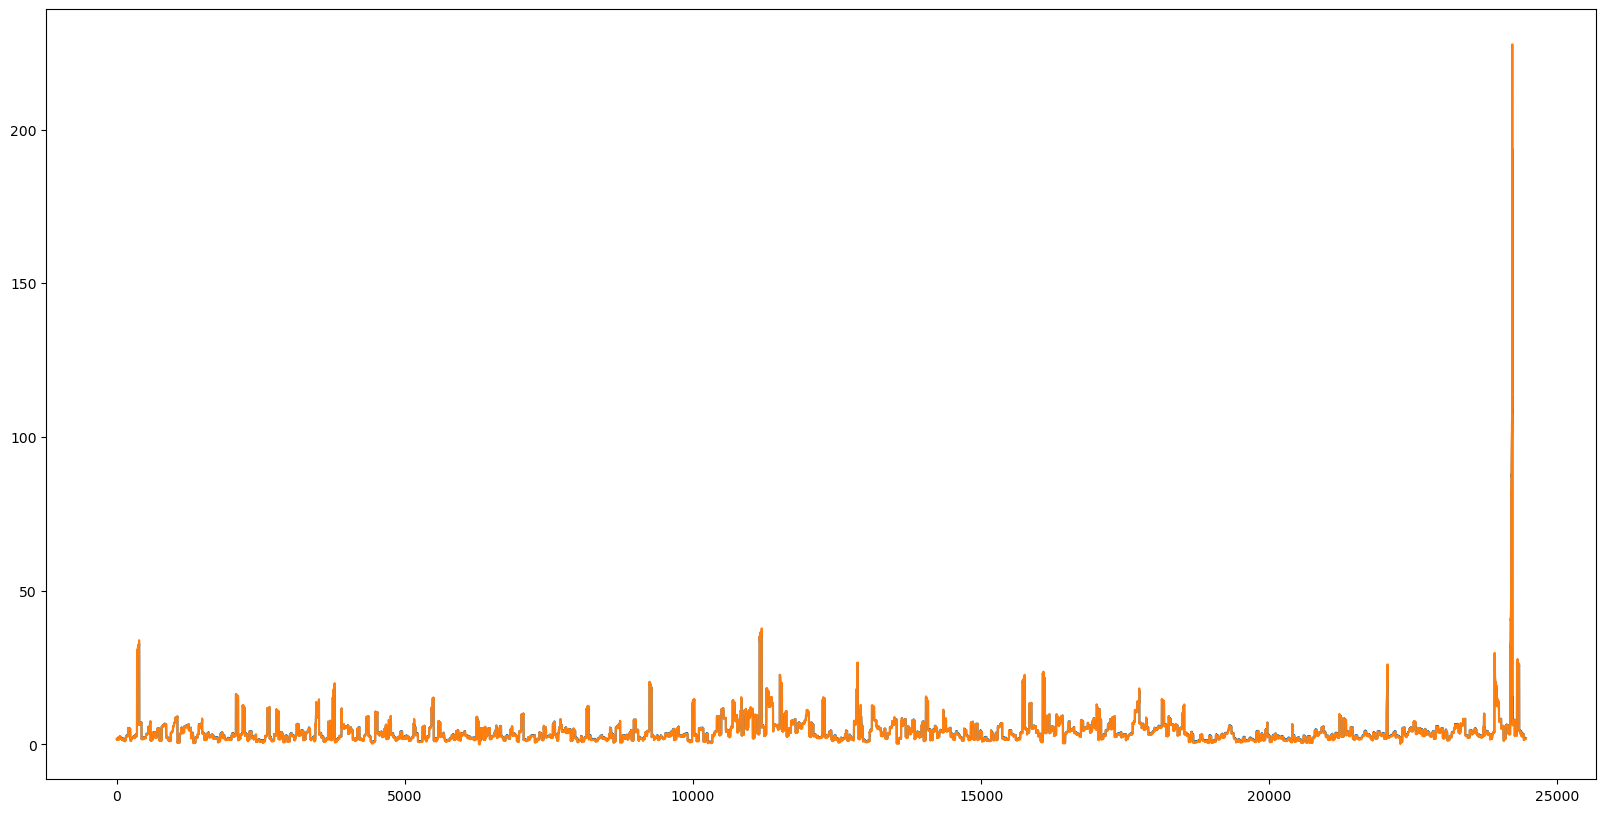

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [40]:
def smape(actual, forecast):
  n = len(actual)
  error_sum = 0
  for i in range(n):
    error_sum += abs(actual[i] - forecast[i]) / (abs(actual[i]) + abs(forecast[i]))
  return 100 * (error_sum / n)

In [42]:
smape(true, preds)

array([5.717951], dtype=float32)